<a href="https://colab.research.google.com/github/RyanZR/ColabDock-Vina/blob/main/%F0%9F%8D%8AUNION_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🍊 **UNION_V2**
_Virt**U**al Scree**N**ing S**I**th Aut**O**Dock Vi**N**a 1.**2**.0_ is a Jupyter Notebook written to perform molecular docking on large virtual compound library using *AutoDock Vina* and analyse the docking results.



Proceed to [MOUNTAIN_V2.pynb](https://colab.research.google.com/github/RyanZR/ColabDock-Vina/blob/main/%F0%9F%8D%8AMOUNTAIN_V2.ipynb) to perform single molecular docking.

---
---
# **Setting Up the Environment for Molecular Docking**

Before starting, we need to install all the necessary software and dependecies to perform molecular docking. 

+ py3Dmol (https://pypi.org/project/py3Dmol/)
+ biopython (https://biopython.org/)
+ condacolab (https://github.com/con)
+ OpenBabel (https://github.com/openbabel/openbabel)
+ MGLtools (https://ccsb.scripps.edu/mgltools/)
+ AutoDock Vina (https://vina.scripps.edu/)

In [ ]:
# @title **Install dependencies and softwares**
# @markdown It will take a few minutes. It will **restart** after the installation. 

%%capture
# Delete sample data
!rm -r /content/sample_data

# Install dependencies
!pip install py3Dmol
!pip install pybel
!pip install rdkit-pypi

# Setup AutoDock Vina
!wget https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.0/vina_1.2.0_linux_x86_64 -O vina
!chmod u+x vina

# Setup Conda
!pip install -q condacolab
import condacolab
condacolab.install_miniconda()

# Install other packages
!conda install -c conda-forge -c bioconda mgltools=1.5.7 biopython=1.78 openbabel=2.4.1 zlib=1.2.11 xlsxwriter --yes
!rm /content/condacolab_install.log

In [ ]:
# @title **Import Python modules**
# @markdown This allow Python accessible to the neccessary modules.

# Import modules
import os
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

import math
import pybel
import timeit
import shutil
import py3Dmol
import xlsxwriter
import numpy as np
import pandas as pd
import urllib.request

from pathlib import Path
from ipywidgets import interact
from IPython.display import display
from Bio.PDB import PDBIO, PDBParser
from google.colab import drive,files

from rdkit import Chem
from rdkit.Chem import rdFMCS, AllChem, Draw, PandasTools
from rdkit.Chem.Draw import DrawingOptions, IPythonConsole

%matplotlib inline

# Capture python output
class Hide:
  def __enter__(self):
    self._original_stdout = sys.stdout
    sys.stdout = open(os.devnull, "w")
  
  def __exit__(self, exc_type, exc_val, exc_tb):
    sys.stdout.close()
    sys.stdout = self._original_stdout

# Define common variables
colors = ["red","orange","yellow","lime","green","cyan","teal","blue","violet","purple","pink","gray","brown","white","black"] 
model = ["","cartoon","stick","line"]
io = PDBIO()
parser = PDBParser()

print("> Installation done")
print("> Import done")
print("> Environment ready for docking")

In [ ]:
# @title **Setup alias for Vina**
# @markdown This create an alias for AutoDock Vina.

# Setup alias for Vina
%alias vina /content/vina

print("> Alias '%vina' created")

In [ ]:
# @title **Create folders**
# @markdown Enter a **Jobname** without space. This create a folder for protein, ligand, experimental and docking.

# Define path of folder
Jobname = "7KNX_VS" #@param {type: "string"}
dir = os.path.abspath(".")
work_dir = os.path.join(dir,Jobname)
protein_folder = os.path.join(work_dir,"protein")
ligand_folder = os.path.join(work_dir,"ligand")
experimental_folder = os.path.join(work_dir,"experimental")
docking_folder = os.path.join(work_dir,"docking")

# Create folder if folder have not exists
folder = [work_dir,protein_folder,ligand_folder,experimental_folder,docking_folder]
for f in folder:
  if os.path.exists(f):
    print("> %s already exists" % f)
  if not os.path.exists(f):
    os.mkdir(f)
    print("> %s was successfully created" % f)

---
---
# **Preparing the Protein**

The first step in docking is to have a structure of a given targer protein. While in some cases a high-quality comparative model will be used, most cases start with an experimentally (X-ray, NMR, cryoEM) solved three-dimensional structure. 

In such cases, a given target protein structure can be downloaded from the [Protein Data Bank (PDB)](https://www.rcsb.org/pdb) using a given accession ID.  We can directly download this structure in `.pdb` file format.

In [ ]:
# @title **Generate protein PDB file**
# @markdown Enter PDB accession ID to download targeted protein.

# Define variables
PDB_ID = "7KNX" # @param {type:"string"}
protein = PDB_ID
protein_pdb = protein + ".pdb"
protein_prot = protein + "_prot"
protein_prot_pdb = protein_prot + ".pdb"
protein_pdb_pfile = os.path.join(protein_folder,protein_pdb)
protein_prot_pfile = os.path.join(protein_folder,protein_prot)
protein_prot_pdb_pfile = os.path.join(protein_folder,protein_prot_pdb)

# Download the protein pdb file
urllib.request.urlretrieve("http://files.rcsb.org/download/" + protein_pdb, protein_pdb_pfile)

print("> " + protein + ".pdb" + " successfully created in " + protein_folder)

> 7KNX.pdb successfully created in /content/7KNX_VS/protein


In [ ]:
# @title **Extract protein**
# @markdown This extract **amino acids** from protein pdb file downloaded. In term of file structure, the **ATOM** lines will be extracted into a new file. Protein subunits will also be extracted as their own separate file.

# Write lines that contain #string "ATOM" into a new file
with open(protein_prot_pdb_pfile,"w") as g:
  f = open(protein_pdb_pfile,"r")
  for line in f:
    row = line.split()
    if row[0] == "ATOM":
      g.write(line)
  print("> Protein extracted")
print("> " + protein_prot_pdb + " successfully created in " + protein_folder)

# Separate protein subunits
def separate_protein(input):
  structure  = parser.get_structure("X", input)
  chainList = [chain for chain in structure.get_chains()]
  chainLen = len(chainList)
  print("> %s of subunit(s) detected" % chainLen)
  if chainLen > 1:
    for chain in chainList:
      io.set_structure(chain)
      io.save(protein_prot_pfile + "_" + chain.get_id() + ".pdb")
      print("> " + protein_prot + "_%s.pdb successfuly created in " % chain.get_id() + protein_folder)

separate_protein(protein_prot_pdb_pfile)

> Protein extracted
> 7KNX_prot.pdb successfully created in /content/7KNX_VS/protein
> 4 of subunit(s) detected
> 7KNX_prot_A.pdb successfuly created in /content/7KNX_VS/protein
> 7KNX_prot_B.pdb successfuly created in /content/7KNX_VS/protein
> 7KNX_prot_C.pdb successfuly created in /content/7KNX_VS/protein
> 7KNX_prot_D.pdb successfuly created in /content/7KNX_VS/protein


In [ ]:
# @title **Parameterise protein with Gasteiger charges** 
# @markdown Enter the protein to be parameterised. This add polar hydrogen to the protein and parameterise it with Gasteiger charge using MGLtools. The protein will be converted to **pdbqt** file. In addition, this also fixes the OpenBabel out-of-format conversion bug.

# Define variables
Target_protein = "7KNX_prot_A.pdb" #@param {type:"string"}
PROTEIN = os.path.splitext(Target_protein)[0]
PROTEIN_pdb = PROTEIN + ".pdb"
PROTEIN_pdbqt = PROTEIN + ".pdbqt"
PROTEIN_pre_pdbqt = PROTEIN + "_pre.pdbqt"
PROTEIN_pdb_pfile = os.path.join(protein_folder,PROTEIN_pdb)
PROTEIN_pdb_dfile = os.path.join(docking_folder,PROTEIN_pdb)
PROTEIN_pdbqt_dfile = os.path.join(docking_folder,PROTEIN_pdbqt)

# Add polar hydrogen and parameterise with MGLtools
with Hide():
  !prepare_receptor4.py -r $PROTEIN_pdb_pfile -o $PROTEIN_pdbqt_dfile -A hydrogens -U nphs_lps -v
shutil.copy(PROTEIN_pdb_pfile,docking_folder)

print("> " + PROTEIN_pdbqt + " successfully created in " + docking_folder)

> 7KNX_prot_A.pdbqt successfully created in /content/7KNX_VS/docking


---
---
# **Preparing the Experimental Ligand**
We can compare the docking poses for verification with the experimentally solved pose for the ligand. This step is **optional**.

In [ ]:
# @title **Generate experimental ligand PDB file**
# @markdown Enter the **name** assigned for the experimental ligand. 

# Defines variables
Experimental_ligand_name = "QOV" #@param {type:"string"}
eln = Experimental_ligand_name
eln_pdb = eln + ".pdb"
eln_efile = os.path.join(experimental_folder,eln)
eln_pdb_efile = os.path.join(experimental_folder,eln_pdb)

# Extract exp_ligand
with open(eln_pdb_efile,"w") as g:
  f = open(protein_pdb_pfile,"r")
  for line in f:
    row = line.split()
    if eln in row:
      g.write(line)
  print("> Experimental ligands extracted")

print("> " + eln_pdb + " successfully created in " + experimental_folder)

> Experimental ligands extracted
> QOV.pdb successfully created in /content/7KNX_VS/experimental


In [ ]:
# @title **Extract experimental ligands**
# @markdown This extract all the **experimental ligands** from the pdb file and export it as separate files if any.

# Separate different experimental ligandsz
def separate_exp(input):
  structure  = parser.get_structure("X", input)
  chainList = [chain for chain in structure.get_chains()]
  chainLen = len(chainList)
  print("> %s ligands(s) detected" % chainLen)
  if chainLen > 1:
    for chain in chainList:
      io.set_structure(chain)
      io.save(eln_efile + "_" + chain.get_id() + ".pdb")
      print("> " + eln + "_%s.pdb successfuly created in " % chain.get_id() + experimental_folder)
separate_exp(eln_pdb_efile)

> 4 ligands(s) detected
> QOV_A.pdb successfuly created in /content/7KNX_VS/experimental
> QOV_B.pdb successfuly created in /content/7KNX_VS/experimental
> QOV_C.pdb successfuly created in /content/7KNX_VS/experimental
> QOV_D.pdb successfuly created in /content/7KNX_VS/experimental


In [ ]:
# @title **Choose exprimental model**
# @markdown Enter a target experimental ligand for comparison.

# Define variables
Target_exp = "QOV_A.pdb" #@param {type:"string"}
EXP = Target_exp[:-4]
EXP_pdb = EXP + ".pdb"
EXP_mol2 = EXP + ".mol2"
EXP_pdb_efile = os.path.join(experimental_folder,EXP_pdb)
EXP_pdb_dfile = os.path.join(docking_folder,EXP_pdb)
EXP_mol2_dfile = os.path.join(docking_folder,EXP_mol2)

# Copy file to docking_folder
shutil.copy(EXP_pdb_efile,docking_folder)
print("> " + EXP_pdb + " successfully created in " + docking_folder)

> QOV_A.pdb successfully created in /content/7KNX_VS/docking


---
---
# **Preparing the Ligand**

We now need to prepare the ligand that will be used for virtual screening. 

In [ ]:
# @title **Provide ligands file**
# @markdown Upload a ligand csv file onto **ligand folder**. The file should only consist of 2 columns with headers **Name** and **SMILES**.

Ligand_csv_filename = "ligand.csv" #@param {type:"string"}
LIGANDs = "Lig_"
LIGAND_csv = Ligand_csv_filename
LIGAND_csv_file = os.path.join(ligand_folder,LIGAND_csv)

try:
  df = pd.read_csv(LIGAND_csv_file,dtype = str)
except Exception as e:
  print(e)

df

,ID,SMILES
0,01,CCCN=CC1=CC=CC=C1
1,02,CCC(C)N=CC1=CC=CC=C1
2,03,C1CC1CN=CC2=CC=CC=C2
3,04,CC(C)CCN=CC1=CC=CC=C1
4,05,CN(C)CCCN=CC1=CC=CC=C1
5,06,COC(CN=CC1=CC=CC=C1)OC
6,07,CC(C)(C)N=CC1=CC=CC=C1
7,08,CCN(CC)CCN=CC1=CC=CC=C1
8,09,C1=CC=C(C=C1)C=NCC(CO)O
9,10,C1CNCCC1CN=CC2=CC=CC=C2


In [ ]:
# @title **Parameterize ligand(s) with Gasteiger charges**
# @markdown This convert **SMILES** to **mol2** file while simultaneously performing energy minimization using **`Universal Force Field (UFF)`** at 10000 iterations. After that, this add polar hydrogen to the protein and parameterise it with Gasteiger charge using MGLtools. The ligand(s) will be converted to **pdbqt** file.

count = 0

for n,m in zip(df["ID"],df["SMILES"]):
  with open(os.path.join(ligand_folder,LIGANDs + str(n) + ".smi"),"w") as f:
    f.write(m)

with Hide():
  for f in os.listdir(ligand_folder):
    if f.endswith(".smi"):
      count += 1
      fn = os.path.splitext(f)[0]
      !obabel $ligand_folder/$f -O $fn".mol2" --gen3d --best --canonical --minimize --ff UFF --steps 10000 --sd
  for f in os.listdir(dir):
    if f.endswith(".mol2"):
      fn = os.path.splitext(f)[0] 
      os.makedirs(os.path.join(docking_folder,fn))
      !prepare_ligand4.py -l $f -o $docking_folder/$fn/$fn".pdbqt" -U nphs_lps -v
      shutil.move(f,ligand_folder)

print("> " + str(count) + " ligand(s).smi successfully converted to .mol2 files")
print("> " + str(count) + " ligand(s).mol2 successfully converted to .pdbqt files in " + docking_folder)

> 50 ligand(s).smi successfully converted to .mol2 files
> 50 ligand(s).mol2 successfully converted to .pdbqt files in /content/7KNX_VS/docking


---
---
# **Setting Up Molecular Docking**
It is necessary to define search space for docking on a target protein through the use of grid box. The grid box is usually centered within the binding, active or allosteric site of target protein and its size should be sufficiently enough such that important binding residues are contained inside the box.

In [ ]:
# @title **Generate docking config file**
# @markdown Click to generate config file for AutoDock Vina.

X = "55" #@param {type:"string"}
Y = "48" #@param {type:"string"}
Z = "-52" #@param {type:"string"}
WIDTH = "15" #@param {type:"string"}
HEIGHT = "17" #@param {type:"string"}
LENGTH = "12" #@param {type:"string"}

config = "config_file"
config_dfile = os.path.join(docking_folder,config)

with open(config_dfile,"w") as f:
  f.write("center_x = %s \n" % X)
  f.write("center_y = %s \n" % Y)
  f.write("center_z = %s \n" % Z)
  f.write("\n")
  f.write("size_x = %s \n" % WIDTH)
  f.write("size_y = %s \n" % HEIGHT)
  f.write("size_z = %s \n" % LENGTH)

print("> " + config + " successfully created in " + docking_folder)

> config_file successfully created in /content/7KNX_VS/docking


---
---
# **Performing Molecular Docking**
Autodock Vina will performing the docking stimulation with a progress bar (if running as expected). This simulation may take longer than 5 min, depends on number of ligand(s).

In [ ]:
# @title **Run AutoDock Vina**
# @markdown Click to perform molecular docking on targeted protein.

# Define varibles
totalRuntime = 0
n = 0

print("   Docking Ligand   |   Runtime   |   Est. Time Left   |   Completion   ")
print("------------------------------------------------------------------------")

# Executing AutoDock Vina with our configuration file
os.chdir(docking_folder)
files = sorted([ os.path.join(docking_folder,f + "/" + f + ".pdbqt") for f in os.listdir(docking_folder) if "Lig_" in f ])
for f in files:
  fn = os.path.splitext(f)[0]
  fn_log = fn + "_log.txt"
  start = timeit.default_timer()
  with Hide():
    with open(fn_log, "w") as w:
      with contextlib.redirect_stdout(w):
        %vina --receptor $PROTEIN_pdbqt_dfile --ligand $f --out $fn"_output.pdbqt" --config $config_dfile --exhaustiveness 32 --verbosity 2
    with open(fn_log, 'r') as r:
      data = r.read().splitlines(True)
    with open(fn_log, 'w') as o:
        o.writelines(data[1:])
  stop = timeit.default_timer()
  runtime = stop - start
  totalRuntime += runtime
  avgrt = int(totalRuntime/(n+1))
  timeleft = int(avgrt*(len(files)-n)-avgrt)
  percentage = int((n+1)/len(files)*100)
  runtimeO = str(np.round(runtime,2)) + " s"
  timeLeftO = str(int(timeleft//3600)).zfill(2) + ":" + str(int(timeleft%3600//60)).zfill(2) + ":" + str(int(timeleft%60)).zfill(2)
  percentageO = str(percentage) + " %"
  n += 1
  print(f"{fn[len(os.path.dirname(fn)) + 1:]:^20} {runtimeO:^13} {timeLeftO:^20} {percentageO:^16}")
os.chdir(dir)

print("")
print("> Molecular docking completed")

   Docking Ligand   |   Runtime   |   Est. Time Left   |   Completion   
------------------------------------------------------------------------
       Lig_01           33.34 s          00:26:57             2 %       
       Lig_02           34.03 s          00:26:24             4 %       
       Lig_03           35.22 s          00:26:38             6 %       
       Lig_04           47.51 s          00:28:22             8 %       
       Lig_05           66.86 s          00:32:15             10 %      
       Lig_06           62.21 s          00:33:44             12 %      
       Lig_07           26.78 s          00:30:49             14 %      
       Lig_08           85.11 s          00:33:36             16 %      
       Lig_09           61.43 s          00:34:10             18 %      
       Lig_10           65.49 s          00:34:00             20 %      
       Lig_11           31.69 s          00:31:51             22 %      
       Lig_12           44.28 s          00:31:02  

In [ ]:
# @title **Process output file**
# @markdown This convert output and experimental ligand files into **sdf** file for analysis and export 9 docking poses as separate **pdb** file for viewing.
LIGAND_out_pdbqt_dfiles = sorted([ os.path.join(docking_folder,f + "/" + f + "_output.pdbqt") for f in os.listdir(docking_folder) if "Lig_" in f ])
LIGAND_out_sdf_dfiles = sorted([ os.path.join(docking_folder,f + "/" + f + "_output.sdf") for f in os.listdir(docking_folder) if "Lig_" in f ])

for inf,outf in zip(LIGAND_out_pdbqt_dfiles,LIGAND_out_sdf_dfiles):
  in_LIGAND_out_pdbqt = pybel.readfile("pdbqt",inf)
  out_LIGAND_out_sdf = pybel.Outputfile("sdf",outf,True)

  for p in [ m for m in in_LIGAND_out_pdbqt ]:
    p.data.update({"POSE":p.data["MODEL"]})
    p.data.update({"SCORE":p.data["REMARK"].split()[2]})
    p.data.update({"RMSD_LB_BP":p.data["REMARK"].split()[3]})
    p.data.update({"RMSD_UB_BP":p.data["REMARK"].split()[4]})
    del p.data["MODEL"], p.data["REMARK"], p.data["TORSDO"]
    out_LIGAND_out_sdf.write(p)
  out_LIGAND_out_sdf.close()

with Hide():
  for f in LIGAND_out_pdbqt_dfiles:
      fn = os.path.join(docking_folder,f)
      fn_out_dfile = fn[:-12]
      !obabel $fn -O $fn_out_dfile".pdb" -m 
  !obabel $EXP_pdb_dfile -O $EXP_mol2_dfile -h

print("> " + len(LIGAND_out_sdf_dfiles) + " processed ...") 

---
---
# **Analysing Docking Results**

The final step is analyse the docking data and setup 3D viewer to display and analyse our docking results.

In [ ]:
# @title **Setup analysis**
# @markdown This setup multiple functions to calculate RMSD and display results. 
best_pose = Chem.MolFromMol2File(EXP_mol2_dfile)
best_pose.SetProp("_Name",EXP_pdb[:-4])

# Calculate RMSD
def get_rmsd(ref, target):
    distances = []
    r = rdFMCS.FindMCS([ref,target])
    a = ref.GetSubstructMatch(Chem.MolFromSmarts(r.smartsString))
    b = target.GetSubstructMatch(Chem.MolFromSmarts(r.smartsString))   
    for atomA,atomB in list(zip(a,b)):
      pos_A = ref.GetConformer().GetAtomPosition(atomA)
      pos_B = target.GetConformer().GetAtomPosition(atomB)
      coord_A = np.array((pos_A.x,pos_A.y,pos_A.z))
      coord_B = np.array((pos_B.x,pos_B.y,pos_B.z))
      dist_numpy = np.linalg.norm(coord_A - coord_B)        
      distances.append(dist_numpy)
    rmsd = np.round(math.sqrt(1/len(distances)*sum([i*i for i in distances])),3)
    return rmsd

# Display docking results in Pandas DataFrame
def vina_result(file):
  try:
    LIGAND = file[len(os.path.dirname(file))+1:-11]
    vina_pose = PandasTools.LoadSDF(file)
    vina_pose["ID"] = [ LIGAND + "_" + vina_pose.loc[i,"POSE"] for i in vina_pose.index ]
    vina_pose["RMSD_EL"] = [ get_rmsd(best_pose,vina_pose.loc[i,"ROMol"]) for i in vina_pose.index ]
    vina_pose["RMSD_EL"] = pd.to_numeric(vina_pose["RMSD_EL"])
    vina_pose["RMSD_LB_BP"] = pd.to_numeric(vina_pose["RMSD_LB_BP"])
    vina_pose["RMSD_UB_BP"] = pd.to_numeric(vina_pose["RMSD_UB_BP"])
    vina_pose["cRMSD"] = np.round((vina_pose["RMSD_EL"] + vina_pose["RMSD_LB_BP"] + vina_pose["RMSD_UB_BP"]) / 3,3)
    vina_pose = vina_pose[["ID","POSE","SCORE","RMSD_EL","RMSD_LB_BP","RMSD_UB_BP","cRMSD","ROMol"]]
    return vina_pose
  except Exception as e:
    print(e)

,ID,POSE,SCORE,RMSD_EL,RMSD_LB_BP,RMSD_UB_BP,cRMSD,ROMol
0,Lig_39_1,1,-6.775,2.775,0.0,0.0,0.925,
1,Lig_43_1,1,-6.689,3.150,0.0,0.0,1.050,
2,Lig_37_1,1,-6.495,6.983,0.0,0.0,2.328,
3,Lig_47_1,1,-6.470,6.672,0.0,0.0,2.224,
4,Lig_44_1,1,-6.332,6.989,0.0,0.0,2.330,
5,Lig_48_1,1,-6.328,2.986,0.0,0.0,0.995,
6,Lig_50_1,1,-6.211,5.571,0.0,0.0,1.857,
7,Lig_28_1,1,-6.049,2.062,0.0,0.0,0.687,
8,Lig_45_1,1,-6.012,5.044,0.0,0.0,1.681,
9,Lig_30_1,1,-5.804,2.017,0.0,0.0,0.672,

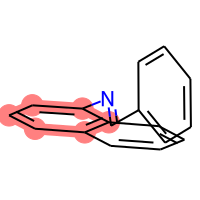
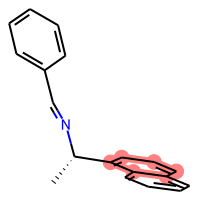
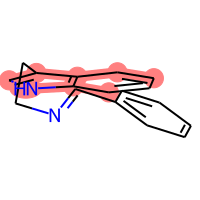
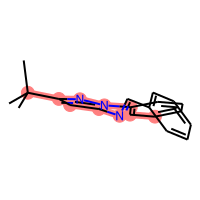
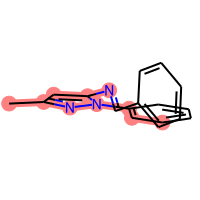
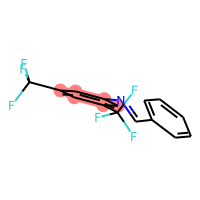
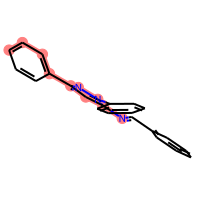
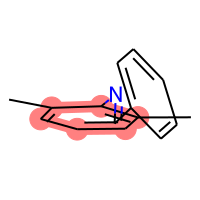
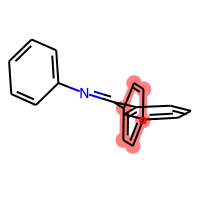
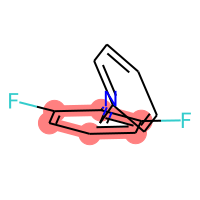

In [ ]:
# @title **Rank binding affinity**
# @markdown This rank the binding affinity ascendingly. Noted that:
# @markdown + **`RMSD_EL`** = RMSD vs Exp. Lig.
# @markdown + **`RMSD_LB_BP`** = RMSD Lower Bound vs Best Pose
# @markdown + **`RMSD_LB_UP`** = RMSD Upper Bound vs Best Pose
# @markdown + **`cRMSD`** = Consensus RMSD
log_files = sorted([ os.path.join(docking_folder,f + "/" + f + "_log.txt") for f in os.listdir(docking_folder) if "Lig_" in f ])
vina_rank = pd.DataFrame()

for f in LIGAND_out_sdf_dfiles:
  vina_rank = vina_rank.append(vina_result(f).iloc[0])
  
vina_rank.sort_values("SCORE",ascending = False, ignore_index = True,inplace = True)
result_xlsx_dfile = os.path.join(docking_folder,"rank_output.xlsx")
PandasTools.SaveXlsxFromFrame(vina_rank,result_xlsx_dfile,molCol = "ROMol")

vina_rank.head(10)

,ID,POSE,SCORE,RMSD_EL,RMSD_LB_BP,RMSD_UB_BP,cRMSD,ROMol
0,Lig_09_1,1,-5.253,2.173,0.000,0.000,0.724,
1,Lig_09_2,2,-5.246,2.211,0.088,1.346,1.215,
2,Lig_09_3,3,-5.219,2.221,1.001,1.257,1.493,
3,Lig_09_4,4,-5.202,2.194,1.161,1.904,1.753,
4,Lig_09_5,5,-5.182,2.138,1.034,2.063,1.745,
5,Lig_09_6,6,-5.008,2.035,3.496,4.228,3.253,
6,Lig_09_7,7,-4.731,4.728,3.068,5.989,4.595,
7,Lig_09_8,8,-4.704,1.999,2.449,2.522,2.323,
8,Lig_09_9,9,-4.621,2.248,1.455,1.754,1.819,

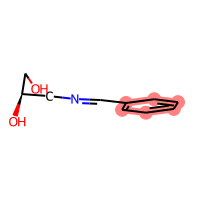
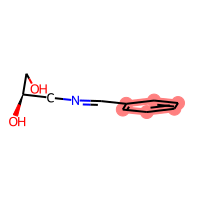
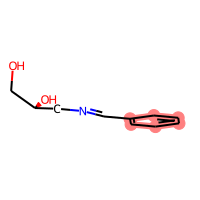
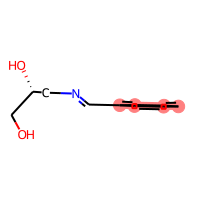
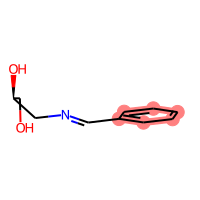
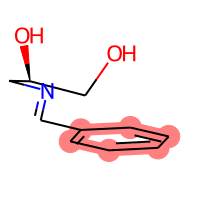
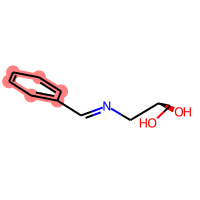
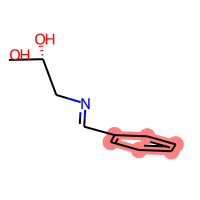
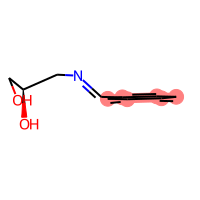

In [ ]:
# @title **Show RMSD of ligand pose** {run : "auto"}
# @markdown This show the **RMSD** of the ligand among 9 other poses.
Select_ligand = "Lig_09" #@param {type:"string"} 

LIGAND_out_sdf = Select_ligand + "_output.sdf"
LIGAND_out_sdf_dfile = os.path.join(docking_folder,Select_ligand + "/" + LIGAND_out_sdf)
vina_result(LIGAND_out_sdf_dfile)

In [ ]:
# @title **Setup 3D structure viewer**
# @markdown This create 3D viewer for the protein, docked ligand and the experimental ligand.

def chain_check(input):
  chainId = []
  structure  = parser.get_structure("X",input)
  numberOfChain = len(list(structure.get_chains()))
  return numberOfChain

# Setup 3D structure
def view_prot_exp_lig(bxi,byi,bzi,
                      bxf,byf,bzf,
                      inputP,
                      inputPP,
                      inputL,
                      inputE,
                      style = "cartoon",
                      types = "color",
                      color = "spectrum",
                      highlight = "red",
                      showSubunit = False,
                      addBS = False,
                      addLine = False,
                      showRes = "",
                      showAllRes = False,
                      showVDWsurface = False,
                      showPartProt = False,
                      showExpLig = False,
                      showLig = False,
                      showAllPose = False,
                      showBestPose = False,
                      showGrid = False):
  print("> " + "Showing " + inputP[len(docking_folder)+1:] + " ...")
  
  count = 0 # Start from 0
  mview = py3Dmol.view(1500, 1500)
  mview.setViewStyle({'style':'outline','color':'black','width':0.1})
  count += 1 # At 1
  
  mol1 = open(inputP,"r").read()
  mview.addModel(mol1,"pdb")  
  mview.setStyle(
      {"model":count},
      {style:{types:color,"style":"rectangle"}})
  if showSubunit and chain_check(inputP) > 1:
    for n,m in zip(range(chain_check(inputP)),colors):
      mview.setStyle(
          {"and":[{"model":count},{"chain":(chr(65+n))}]},
          {style:{types:(m if style == "cartoon" else m + "Carbon")}})
      mview.addLabel(
          "Subunit " + chr(65+n),
          {"fontColor":m,"backgroundOpacity": 0.7,"alignment":"topLeft"},
          {"and":[{"model":count},{"chain":(chr(65+n))}]})
  if addBS:
    mview.addStyle(
      {"model":count},
      {"stick":{"colorscheme":"whiteCarbon"}})
  if addLine:
    mview.addStyle(
      {"model":count},
      {"line":{"colorscheme":"whiteCarbon"}})  
  if showRes is not "":
    res = showRes.split(",")
    mview.addStyle(
        {"and":[{"model":count},{"resi": res}]},
        {"stick":{"colorscheme":highlight + "Carbon"}})
    mview.addResLabels(
        {"and":[{"model":count},{"resi": res}]},
        {"backgroundOpacity": 0.7,"fontColor":highlight,"inFront":False})
  if showAllRes:
    mview.addResLabels(
        {"and":[{"model":count},{"resi": "1-9999999"}]},
        {"backgroundOpacity":0.7,"inFront":False})
  if showVDWsurface:
    mview.addSurface(
        py3Dmol.VDW,
        {"color":"white","opacity":0.6},
        {"model":count})

  if showPartProt and os.path.exists(inputPP):
    count += 1
    mol2 = open(inputPP,"r").read()
    mview.addModel(mol2,"pdb")
    mview.setStyle(
        {"model":count},
        {"cartoon":{"color":"orange"}})
    mview.addStyle(
        {"model":count},
        {"stick":{"colorscheme":"orangeCarbon"}})
    print("> Showing " + inputPP[len(docking_folder)+1:] + " (orange) ...")
    
  if showExpLig:
    count += 1
    mol3 = open(inputE,"r").read()
    mview.addModel(mol3,"pdb")
    mview.setStyle(
        {"model":count},
        {"stick":{"color":"gray","radius":0.2}})
    print("> Showing " + inputE[len(docking_folder)+1:] + " (gray) ...")
  
  if showLig:
    count += 1
    mol4 = open(inputL,"r").read()
    mview.addModel(mol4,"pdb")
    mview.setStyle(
        {"model":count},
        {"stick":{"colorscheme":"redCarbon",}})
    print("> Showing " + inputL[len(os.path.dirname(inputL))+1:] + " (red) ...")
  
  if showAllPose:
    count += 1
    pose = sorted([ os.path.join(os.path.dirname(inputL),f) for f in os.listdir(os.path.dirname(inputL)) if f.endswith(".pdb") ])
    pose.remove(inputL[len(docking_folder)+1:]) if inputL[len(docking_folder)+1:] in pose else None
    for f,n in zip(pose,range(len(pose))):
      fs = "".join(f)
      mol5 = open(os.path.join(docking_folder,fs),"r").read()
      mview.addModel(mol5,"pdb")
      mview.setStyle(
          {"model":n + count},
          {"stick":{"color":"blue","opacity":0.5,"radius":0.2}})
    print("> Showing all poses ...")
  
  if showBestPose:
    count += 1
    pose = sorted([ f + "_1.pdb" for f in os.listdir(docking_folder) if "Lig_" in f ]) 
    pose.remove(inputL[len(docking_folder)+1:]) if inputL[len(docking_folder)+1:] in pose else None
    for f,n in zip(pose,range(len(pose))):
      fs = "".join(f)
      mol6 = open(os.path.join(docking_folder,fs[:-6] + "/" + fs),"r").read()
      mview.addModel(mol6,"pdb")
      mview.setStyle(
          {"model":n + count},
          {"stick":{"color":"green","opacity":0.5,"radius":0.2}})
    print("> Showing all best poses ...")

  print("")
  mview.setBackgroundColor("0xFFFFFF")
  mview.enableFog(True)
  mview.zoomTo()
  mview.show()

print("> 3D structure viewer created")

> 3D structure viewer created


In [ ]:
# @title **Display docking** {run: "auto"}
# @markdown Enter the docking pose to be viewed. This display protein, docked ligand and experimental ligand in 3D space with multiple apperance choices.

# @markdown ---

# @markdown **PROTEIN MODEL**
# Define variable
Model = "None" #@param ["None","Line Model","Stick Model", "Ribbon Model"]
Model_colour = "white" #@param ["red","orange","yellow","green","blue", "violet","purple","white", "black","spectrum"]
View_residues = "" #@param {type:"string"}
Residues_colour = "yellow" #@param ["red","orange","yellow","green","blue", "violet","purple","white", "black"]
Show_all_residues = False #@param {type:"boolean"}
Show_all_subunits = False #@param {type:"boolean"}
Show_VDW_surface = True #@param {type:"boolean"}
Add_stick_model = False #@param {type:"boolean"}
Add_line_model = False #@param {type:"boolean"}
style = ""
types = ""
color = ""

# @markdown ---

# @markdown **PARTNER PROTEIN (Optional)**

# @markdown Upload the partner protein to docking folder and view it here to analyse protein-protein interaction. 
View_partner_protein = "mtdh.pdb" #@param {type:"string"}
Show_partner_protein = False #@param {type:"boolean"}
PP_pdb_dfile = os.path.join(docking_folder,View_partner_protein)

# @markdown ---

# @markdown **LIGAND MODEL**
Ligand_pose = "Lig_39_1.pdb" #@param {type:"string"}
Show_ligand = True #@param {type:"boolean"}
Show_experimental_ligand = True #@param {type:"boolean"}
Show_all_pose = True #@param {type:"boolean"}
Show_best_pose = False #@param {type:"boolean"}
LIGAND_dock_folder = Ligand_pose[:-6] # Lig_AM 
LIGAND_dock_pdb = Ligand_pose # Lig_AM_1.pdb
LIGAND_dock_dfolders = os.path.join(docking_folder,LIGAND_dock_folder) # /content/docking/Lig_AM
LIGAND_dock_pdb_dfile = os.path.join(LIGAND_dock_dfolders,LIGAND_dock_pdb) # /content/docking/Lig_AM/Lig_AM_1.pdb

# Define model
if Model == "None":
  style = ""
  types = ""
if Model == "Line Model":
  style = "line"
  types = "colorscheme"
if Model == "Stick Model":
  style = "stick"
  types = "colorscheme"
if Model == "Ribbon Model":
  style = "cartoon"
  types = "color"
  
# Display 3D structure
@interact
def viewer_four():
  try:
    view_prot_exp_lig(bxi = X,byi = Y,bzi = Z,
                      bxf = WIDTH,byf = HEIGHT,bzf = LENGTH,
                      inputP = PROTEIN_pdb_dfile,
                      inputPP = PP_pdb_dfile,
                      inputL = LIGAND_dock_pdb_dfile,
                      inputE = EXP_pdb_dfile, 
                      style = style,
                      types = types,
                      color = Model_colour,
                      highlight = Residues_colour,
                      addBS = Add_stick_model,
                      addLine = Add_line_model,
                      showSubunit = Show_all_subunits,
                      showRes = View_residues,
                      showAllRes = Show_all_residues,
                      showVDWsurface = Show_VDW_surface,
                      showPartProt = Show_partner_protein,
                      showExpLig = Show_experimental_ligand,
                      showLig = Show_ligand,
                      showAllPose = Show_all_pose,
                      showBestPose = Show_best_pose)
  except Exception as e:
    print(e)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

---
---
# **Save to Google Drive**
Save your docking data in GDrive. 

In [ ]:
# @title **Import Google Drive**
# @markdown This allow data to be stored in Google Drive.

# Flush and mount GDrive
with Hide():
  drive.flush_and_unmount()
  drive.mount("/content/drive", force_remount=True)

print("> Mounted at /content/drive")

> Mounted at /content/drive


In [ ]:
# @title **Store result in Google Drive**
# @markdown Enter the file destination for saving. The folder will be created if not existed. This save all the files created for molecular docking into Google Drive.

# Define varibles
Destination = "/content/drive/MyDrive/Docking" # @param {type:"string"}
destination_folder = os.path.join(Destination,Jobname)

for f in LIGAND_out_sdf_dfiles:
  fn = os.path.basename(f)[:-11]
  data = pd.DataFrame(vina_result(f))
  result_xlsx_dfile = os.path.join(docking_folder, fn + "/" + fn + "_output.xlsx")
  PandasTools.SaveXlsxFromFrame(data,result_xlsx_dfile,molCol = "ROMol")

# Copy file to GDrive
shutil.copytree(work_dir,destination_folder)

print("> Data saved at " + destination_folder)

> Data saved at /content/drive/MyDrive/Docking/7KNX_VS
